#KDD Cup 1998 Data Analysis

- The data we analyzed was taken from the The Second International Knowledge Discovery and Data Mining Tools Competition in 1998.

- The data we used was only a portion of the full data used in competition.

- Objective: To create a regression model in order to predict the donation amounts that individuals are likely to contribute, and to also form a classification model with a binary outcome of 'true'/'false' in terms of whether or not an individual will make a donation.

For more information regarding the data set please visit https://kdd.ics.uci.edu/databases/kddcup98/kddcup98.html

Authors: Zachary N. Combs, M.S. Data Science and Philip D. Remmele, M.S. Data Science

#Loading Modules

In [173]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.lda import LDA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
%matplotlib inline

#Utility Functions

In [174]:
plt.rcParams.update({'font.size': 8})

In [175]:
def drop_var_return_backup(df, col_to_drop):
    backupToDrop = df[col_to_drop]
    df.drop(col_to_drop,axis=1,inplace=True)
    return backupToDrop

In [176]:
def variables_with_missing(df):
    result = []
    col_names = df.columns.tolist()
    for variable in col_names:
        percent = float(sum(df[variable].isnull()))/len(df.index)
        #print variable+":", percent
        if percent != 0:
            result.append(variable)
    return result

In [177]:
def variable_type(df, nominal_level = 3):
    categorical, numeric, nominal = [],[],[]
    for variable in df.columns.values:
        if np.issubdtype(np.array(df[variable]).dtype, int) or np.issubdtype(np.array(df[variable]).dtype, float):
            if len(np.unique(np.array(df[variable]))) <= nominal_level:
                nominal.append(variable)
            else:
                numeric.append(variable)
        else:
            categorical.append(variable)
    return numeric,categorical,nominal

Histogram Function:

In [178]:
def draw_histograms(df, variables, n_rows, n_cols):
    #*********************initialize our figure ***********************#
    fig = plt.figure()
    #********** The i generates the auto-numbering for subplot ********#
    i=1
    #************* The for loop does the following: *****************#
    # define ax as the subplot in the i'th location #
    # get the histogram plot information based on item i.e. InqTimeLast
    # add a plot title for the subplot
    # increment i by 1 (the next subplot space)
    for item in variables:
        ax = fig.add_subplot(n_rows,n_cols,i)
        df[item].hist(bins = 20,ax=ax)
        plt.title(item +' distribution')
        i+=1

    plt.show()

Pie Chart Function:

In [179]:
def draw_piecharts(df, variables, n_rows, n_cols):
    #*********************initialize our figure ***********************#
    fig = plt.figure()
    #********** The i generates the auto-numbering for subplot ********#
    i=1
    #************* The for loop does the following: *****************#
    # define ax as the subplot in the i'th location #
    # get the values needed for a pie chart for the 'item' variable i.e. TARGET
    # add a plot title for the subplot
    # increment i by 1 (the next subplot space)
    for item in variables:
        ax = fig.add_subplot(n_rows,n_cols,i)
        df[item].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title(item +' distribution')
        i+=1

    plt.show()

Numeric Variable Log Transformation:

In [180]:
def add_log_transform(df, variable, indexplus = 1):
    log_variable = "log_" + variable
    #**************** Add one to each value in df[value] and then apply the log function ************#

    onesColumn = np.ones(df[variable].shape[0])
    log_transform = np.add(onesColumn,df[variable]).apply(np.log)
    #************** Get location of the variable ***************#
    varLoc = df.columns.get_loc(variable)

    df.insert(loc=varLoc+indexplus,column=log_variable,value=log_transform)

Sqrt Transform:

In [181]:
def add_sqrt_transform(df, variable, indexplus =1):
    sqrt_variable = "sqrt_" + variable
    sqrt_transform = df[variable].apply(np.sqrt)
    varLoc = df.columns.get_loc(variable)
    df.insert(loc=varLoc+indexplus,column=sqrt_variable,value=sqrt_transform)

Boxplot Function:

In [182]:
def draw_boxplots(df, variables, n_rows, n_cols,by_statement = 'TARGET_B'):
    #*********************initialize our figure ***********************#
    fig = plt.figure()
    #********** The i generates the auto-numbering for subplot ********#
    i=1
    #************* The for loop does the following: *****************#
    # define ax as the subplot in the i'th location #
    # get the histogram plot information based on item i.e. InqTimeLast
    # add a plot title for the subplot
    # increment i by 1 (the next subplot space)
    for item in variables:
        ax = fig.add_subplot(n_rows,n_cols,i)
        df.boxplot(column=item,by=by_statement,ax=ax,return_type='axes')
        plt.title(item)
        i+=1

    plt.show()

Processing Missing Data (Numeric):

In [183]:
def process_missing_numeric_with_dummy(df, variable):
    missing_variable = variable + "_missing"
    df[missing_variable] = np.where(df[variable].isnull(),1,0)
    median = df[variable].median()
    df[variable].fillna(median, inplace= True)
    return df

Data Imputation with Median:

In [184]:
def process_missing_numeric_no_dummy(df, variable):
    median = df[variable].median()
    df[variable].fillna(median, inplace= True)
    return df

Data Partitioning:

In [185]:
def split_train_test_array(arr, test_size=.3):
    from sklearn.cross_validation import train_test_split
    train, test = train_test_split(arr.values, test_size=test_size)
    train_X = train[:, :-1]
    #print train_X.shape
    train_y = train[:, -1]
    #print train_y.shape
    test_X = test[:,:-1]
    test_y = test[:, -1]
    return (train_X,train_y,test_X,test_y)

def split_x_y(train):
    train_X = train[:, :-1]
    train_y = train[:, -1]
    return (train_X,train_y)

def split_train_test_frame(df, test_size=.3):
    from sklearn.cross_validation import train_test_split
    df.reset_index(level=0, inplace=True)

    train, test = train_test_split(df.values, test_size=test_size)
    train_ = df.iloc[train[:,0].astype(int).tolist()]
    test_ = df.iloc[test[:,0].astype(int).tolist()]
    del train_['index']
    del test_['index']
    #train_.to_csv("train.csv")
    #test_.to_csv("test.csv")
    return (train_, test_)

Missing Value Exploration:

In [186]:
def print_variables_pct_missing(df):
    col_names = df.columns.tolist()
    for variable in col_names:
        percent = float(sum(df[variable].isnull()))/len(df.index)
        #print variable+":", percent

Missing Value Imputation for Variable Transformations:

In [187]:
def missing_imputation_for_numeric(df, numeric_with_na):
    for var in numeric_with_na:
        if "log_" in var or "sqrt_" in var:
            process_missing_numeric_no_dummy(df, var)
        else:
            process_missing_numeric_with_dummy(df, var)
    return

In [188]:
def changeValueToNA( value,replaceValue= 0):
    if(value == replaceValue):
        value = np.nan
    return value

Read Data:

In [189]:
def read_data():
    df = pd.read_csv('kddcup98.csv') # Please change this
    assert isinstance(df, pd.DataFrame) # for pycharm code completion
    #print df.head()
    #print df.describe()
    # remove duplicates
    df = df.drop_duplicates()
    # remove rows with dependent variable missing
    #df = df.dropna(subset=['TARGET'])

    return df

Converting Monetary Values to Numeric:

In [190]:
def replace_dollar_comma(string1):
    string1 = str(string1)
    new_string = string1.replace("$","")
    new_string = new_string.replace(",","")
    return new_string

def make_cols_numeric(df,col_names):
    for name in col_names:
        df[name] = df[name].apply(replace_dollar_comma).astype(int)
    return df

Creating Dummy Variables:

In [191]:
def add_dummy_variables(df,varName):
    processed_frame = None
    #*******Concatenate aframe  With Our dummies **********#
    dums=pd.get_dummies(df[varName],prefix=varName)
    dums.drop(dums.columns.values[0],axis=1,inplace=True)
    df2 = pd.concat([df, dums],axis=1)
    df2 = df2.drop(varName,axis=1)
    return df2

Variable Selection Procedure:

In [192]:
def select_among_origin_log_sqrt(train):
    vars = train.columns.tolist()
    train_x, train_y = split_x_y(train.values)
    from sklearn.ensemble import ExtraTreesClassifier
    clf = ExtraTreesClassifier()
    clf.fit(train_x, train_y)
    #print clf.feature_importances_
    variables_with_importance = tuple(zip( clf.feature_importances_, vars))
    #print variables_with_importance
    variables = []
    i=0
    while i < len(variables_with_importance):
        if i + 2 > len(variables_with_importance)-1:
            variables.append(variables_with_importance[i][1])
            i+=1
        elif variables_with_importance[i+1][1] == "log_" + variables_with_importance[i][1]:
            li = list(variables_with_importance[i: (i+3)])
            variables.append(sorted(li, reverse=True)[0][1])
            i=i+3
        else:
            variables.append(variables_with_importance[i][1])
            i+=1
    return variables

Concatenating Selected Variables to Data Frame:

In [193]:
def train_test_keep_some_vars(train, test, variables):
    train_new = train[variables]
    test_new = test[variables]
    return (train_new, test_new)

def put_desired_variable_in_last_column(df,colName):
    var_backup = drop_var_return_backup(df,colName)
    df[colName] = var_backup
    return df

#Classification Model Fitting:

In [194]:
def variable_selection_model_fitting(train, test):
    train_x, train_y = split_x_y(train.values)
    test_x, test_y = split_x_y(test.values)

    # LogisticRegression

    selection_model1 = LogisticRegression()
    rfecv = RFECV(estimator=selection_model1, step=1, cv=StratifiedKFold(train_y, 10), scoring='accuracy')
    selector = rfecv.fit(train_x, train_y)

    #print selector.support_
    #print selector.ranking_
    print("Optimal number of features : %d" % rfecv.n_features_)
    X_new_train = selector.transform(train_x)
    #print X_new_train.shape
    test_x_new = selector.transform(test_x)

    #print "new selection", X_new_train.columns.values

    regr = LogisticRegression()
    regr.fit(X_new_train, train_y)
    print regr
    pred_y = regr.predict(test_x_new)
    print metrics.classification_report(test_y, pred_y)
    print 'Model_Accuracy: \n', metrics.accuracy_score(test_y, pred_y)

    # RandomforestClassifier

    model2 = RandomForestClassifier(n_estimators=25, bootstrap=True)
    model2.fit(train_x, train_y)
    print model2
    predicted = model2.predict(test_x)
    print metrics.classification_report(test_y, predicted)
    print 'Model_Accuracy: \n', metrics.accuracy_score(test_y, predicted)

    # LDA (Linear Discriminate Analysis)

    model3 = LDA()
    model3.fit(train_x, train_y)
    print model3
    predicted = model3.predict(test_x)
    print metrics.classification_report(test_y, predicted)
    print 'Model_Accuracy: \n', metrics.accuracy_score(test_y, predicted)

#Regression Model Fitting:

In [195]:
def variable_selection_model_fitting_regression(df):
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    # create and fit a ridge regression model, testing each alpha
    train_x, train_y = split_x_y(df.values)
    model = Ridge()
    grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
    grid.fit(train_x, train_y)

    opt_alpha = grid.best_estimator_.alpha
    #print opt_alpha

    model = Ridge(alpha=opt_alpha)

    model.fit(train_x, train_y)
    print(model)
    pred_y = model.predict(train_x)
    #mse = np.mean((pred_y - test_y) ** 2) #mean square error
    #rmse = np.sqrt(mse) # RMSE
    rmse = np.sqrt(mean_squared_error(train_y,pred_y))
    from sklearn.metrics import r2_score
    r2 = r2_score(train_y,pred_y)
    print 'r2: \n', r2
    print ("RMSE: %.2f" % rmse)

    #### OLS: Linear Regression

    model2 = LinearRegression()
    model2.fit(train_x, train_y)
    print(model2)

    predicted = model2.predict(train_x)
    # summarize the fit of the model
    mse = np.mean((predicted-train_y)**2) # mean squared error
    rmse = np.sqrt(mse) # rmse

    r2 = r2_score(train_y, predicted)
    print 'r2:\t', r2
    print ("RMSE: %.2f" % rmse)

    #### Random Forest: Regression

    model3 = RandomForestRegressor()
    model3.fit(train_x, train_y)
    print(model3)

    predicted2 = model3.predict(train_x)

    # summarize the fit of the model
    mse = np.mean((predicted2-train_y)**2) # mean squared error
    rmse = np.sqrt(mse) # rmse

    r2 = r2_score(train_y, predicted2)
    print 'r2: \t', r2
    print ("RMSE: %.2f" % rmse)


    return

#Main:

Numeric: ['ID', 'GiftCnt36', 'GiftCntAll', 'GiftCntCard36', 'GiftCntCardAll', 'GiftAvgLast', 'GiftAvg36', 'GiftAvgAll', 'GiftAvgCard36', 'GiftTimeLast', 'GiftTimeFirst', 'PromCnt12', 'PromCnt36', 'PromCntAll', 'PromCntCard12', 'PromCntCard36', 'PromCntCardAll', 'DemAge', 'DemMedHomeValue', 'DemPctVeterans', 'DemMedIncome']
Categorical: ['StatusCat96NK', 'DemCluster', 'DemGender', 'DemHomeOwner']
Nominal: ['TARGET_B', 'StatusCatStarAll']


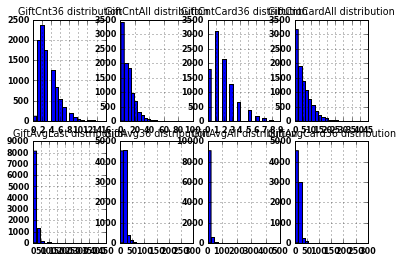

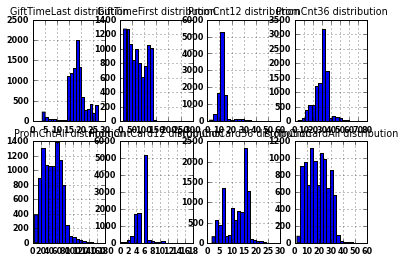

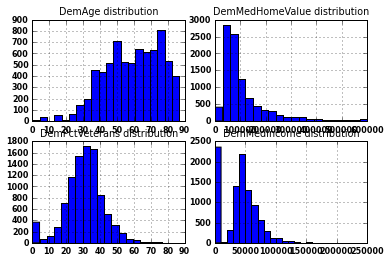

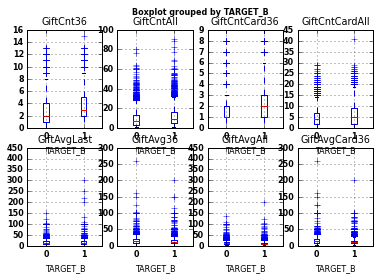

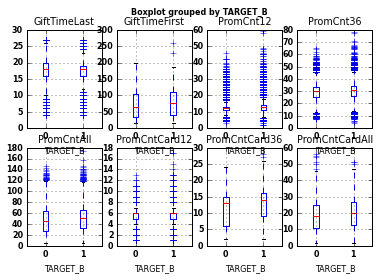

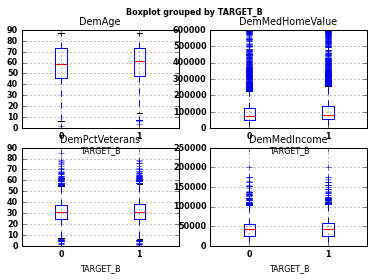

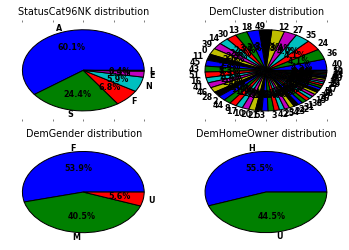

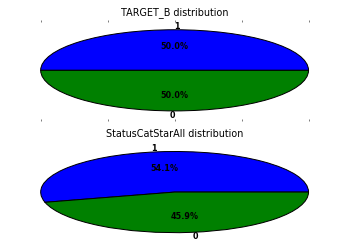

Optimal number of features : 56
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)
             precision    recall  f1-score   support

        0.0       0.55      0.61      0.58      1904
        1.0       0.58      0.52      0.55      1971

avg / total       0.56      0.56      0.56      3875

Model_Accuracy: 
0.562580645161
RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)
             precision    recall  f1-score   support

        0.0       0.55      0.60      0.57      1904
        1.0       0.57      0.52      0.55      1971

avg / total       0.56      0.56      0.56      3875

Model_Accuracy: 
0.560258064516

In [196]:
#****************************Step 1 ************************#
# Read in the dataFrame
# Since we will be using TARGET_D later we first create a copy of TARGET_D Then we can dispose of it for task 1
df = read_data()
TARGET_D_backup = drop_var_return_backup(df,"TARGET_D")
# End Step 1
#****************************Step 2 ************************#
# 2.1
#print df['DemGender'].unique()
#print df['DemCluster'].unique()
#sys.exit(0)
varNames = df.columns.values
#print varNames,"\n\n"
# 2.2
#*** We discovered, the program counts $ and , as categorical, so we have to deal with those ***#
cols_to_make_numeric = ['DemMedHomeValue','DemMedIncome']
df = make_cols_numeric(df,cols_to_make_numeric)
#****** DemCluster is actually nominal (which cluster person belongs to) ****#
df['DemCluster']=df['DemCluster'].astype(np.str)
#****************These are now correct ***********#
numeric,categorical,nominal = variable_type(df)
print "Numeric:" , numeric
print "Categorical:", categorical
print "Nominal:", nominal

#2.3 Draw histograms
histvars1 = ['GiftCnt36', 'GiftCntAll', 'GiftCntCard36', 'GiftCntCardAll', 'GiftAvgLast', 'GiftAvg36', 'GiftAvgAll', 'GiftAvgCard36']
histvars2 = [ 'GiftTimeLast', 'GiftTimeFirst', 'PromCnt12', 'PromCnt36', 'PromCntAll', 'PromCntCard12', 'PromCntCard36', 'PromCntCardAll']
histvars3 = [  'DemAge', 'DemMedHomeValue', 'DemPctVeterans', 'DemMedIncome']

draw_histograms(df,histvars1,2,4)
draw_histograms(df,histvars2,2,4)
draw_histograms(df,histvars3,2,2)

draw_boxplots(df,histvars1,2,4)
draw_boxplots(df,histvars2,2,4)
draw_boxplots(df,histvars3,2,2)

#2.4a Quality Checking false values
df['DemAge']=df['DemAge'].apply(changeValueToNA)
df['DemMedHomeValue']=df['DemMedHomeValue'].apply(changeValueToNA)
df['DemPctVeterans']=df['DemPctVeterans'].apply(changeValueToNA)
df['DemMedIncome']=df['DemMedIncome'].apply(changeValueToNA)

#2.4b Quality Checking skewed distribution
# all the variables in the first histogram figure need transformation
variables_needs_tranform = histvars1
# all the variables in the second histogram figure could use some sort of transformation
variables_needs_tranform.extend(histvars2)
# all the variables for the third histogram figure need transformation
variables_needs_tranform.extend(histvars3)


vars_with_missing = variables_with_missing(df)

# 2.5
draw_piecharts(df, categorical,2,2)
draw_piecharts(df, nominal,2,1)

#****************************Step 3 ************************#
#numeric,categorical,nominal = variable_type(df)
#numeric_with_na = variables_with_missing(df[numeric])
#nominal_with_na = variables_with_missing(df[nominal])
#categorical_with_na = variables_with_missing(df[categorical])

#3.1 Dummy variable creation
for items in categorical:
    df = add_dummy_variables(df,items)

#3.2 transformations
for item in variables_needs_tranform:
    add_sqrt_transform(df, item)
    add_log_transform(df,item)

#print df.columns.values
#3.3 Missing imputation for numeric
numeric,categorical,nominal = variable_type(df)
numeric_with_na = variables_with_missing(df[numeric])
nominal_with_na = variables_with_missing(df[nominal])
categorical_with_na = variables_with_missing(df[categorical])

missing_imputation_for_numeric(df,numeric_with_na)
df.drop('ID',axis=1,inplace=True)
#print df.columns.values
#***********************This is where the TARGET_D and TARGET_B methods split off ***************#
df_b = df.copy()
df_b = put_desired_variable_in_last_column(df_b,"TARGET_B")

#************************ Step 4 *************************#
#Split the dataframe into 60/40
train,test = split_train_test_frame(df_b,test_size=.4)

#************************ Step 5 **************************#
variables_b = select_among_origin_log_sqrt(train)
variables_b.append("TARGET_B") # we add the target variable to the variable list
#print variables_b

train_new, test_new = train_test_keep_some_vars(train, test, variables_b)

#********************** Step 6 and Step 7 *************************#
variable_selection_model_fitting(train_new,test_new)

#****************** Now for TARGET_D ******************#
df_d = df.copy()
df_d['TARGET_D']=TARGET_D_backup
df_d.drop('TARGET_B',axis=1,inplace=True)
df_d.dropna(subset=['TARGET_D'],inplace=True)
#**************** Do Step 5 for TARGET_D ***************#
variables_d = select_among_origin_log_sqrt(df_d)
variables_d.append("TARGET_D")
#print variables_d
df_d=df_d[variables_d]
#******************* Model fitting for TARGET_D **************#
variable_selection_model_fitting_regression(df_d)

- Conclusion: The previous program provides a demonstration of both classification and regression modeling, in order to predict donation amount, and donation outcome (as a binary response). 

- Thanks for your time!

Authors: Philip D. Remmele, M.S. Data Science and Zachary N. Combs, M.S. Data Science